## Lesson 5: Building Reproducible Workflows in ArcGIS Pro

### ArcGIS Notebooks
Over the course of this workshop, we have been building the foundations of a reproducible ArcGIS Notebook. We've taken efforts to automate our analysis by using Arcpy, standardized our working environment, and then documented and discussed our results in ArcGIS Notebooks. These steps were performed over the duration of the workshop, but they can be summarized and explored in complete detail below:

#### Setup Script

In [ ]:
import os
import arcpy
arcpy.env.overwriteOutput = True

WORKSPACE = arcpy.env.workspace
YEARS = ['2019', '2020']
RASTER_PREFIX = 'Kangaroo_Island'
MASK = 'Kangaroo Island'

try:
    for year in YEARS:
        arcpy.env.addOutputsToMap = False
        MOSAIC_DATASET_NAME = '{}_{}'.format(RASTER_PREFIX, year)
        MOSAIC_DATASET_PATH = os.path.join(WORKSPACE, MOSAIC_DATASET_NAME)
        STAC_CSV = os.path.join(arcpy.mp.ArcGISProject("CURRENT").homePath, "Rasters_{0}.csv".format(year))
        # Alternative path:
        # STAC_CSV = os.path.join(arcpy.mp.ArcGISProject("CURRENT").homePath, "\\commondata\\userdata\\Rasters_{0}.csv".format(year))
        
        print("Creating {0} Mosaic Dataset @ {1}".format(MOSAIC_DATASET_NAME, MOSAIC_DATASET_PATH))

        arcpy.management.CreateMosaicDataset(
            in_workspace=WORKSPACE,
            in_mosaicdataset_name=MOSAIC_DATASET_NAME,
            coordinate_system='PROJCS["WGS_1984_UTM_Zone_53S",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",10000000.0],PARAMETER["Central_Meridian",135.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]',
            num_bands=13,
            pixel_type="",
            product_definition="CUSTOM",
            product_band_definitions="AOT # #;Coastal # #;Blue # #;Green # #;Red # #;VRE1 # #;VRE2 # #;VRE3 # #;NIR # #;'Water Vapor' # #;SWIR1 # #;SWIR2 # #;VRE4 # #"
        )

        print("Adding Rasters to {0} Mosaic Dataset".format(MOSAIC_DATASET_NAME))

        arcpy.management.AddRastersToMosaicDataset(
            in_mosaic_dataset=MOSAIC_DATASET_NAME,
            raster_type="Raster Dataset",
            input_path=STAC_CSV,
            update_cellsize_ranges="UPDATE_CELL_SIZES",
            update_boundary="UPDATE_BOUNDARY",
            update_overviews="NO_OVERVIEWS",
            maximum_pyramid_levels=None,
            maximum_cell_size=0,
            minimum_dimension=1500,
            spatial_reference=None,
            filter="",
            sub_folder=None,
            duplicate_items_action="ALLOW_DUPLICATES",
            build_pyramids="BUILD_PYRAMIDS",
            calculate_statistics="CALCULATE_STATISTICS",
            build_thumbnails=None,
            operation_description="",
            force_spatial_reference=None,
            estimate_statistics="ESTIMATE_STATISTICS",
            aux_inputs="QueryPixelFiles NO",
            enable_pixel_cache="NO_PIXEL_CACHE"
        )

        print("Clipping {0} Mosaic Dataset to {1} Feature Class".format(MOSAIC_DATASET_NAME, MASK))

        kangaroo_clip = arcpy.ia.Clip(
            in_raster= MOSAIC_DATASET_NAME,
            aoi= MASK
        )
        
        arcpy.env.addOutputsToMap = True
        arcpy.MakeRasterLayer_management(kangaroo_clip, "Kangaroo_Island_{0}".format(year))
        
        print("Successfully Added {0} to Map".format(MOSAIC_DATASET_NAME))
        print()

except Exception as e:
    print(e)
    arcpy.env.addOutputsToMap = True
    
    geodatabase_rasters = arcpy.ListDatasets()
    for ds in geodatabase_rasters:
        print("Deleting...", ds)
        arcpy.management.Delete(os.path.join(arcpy.env.workspace, ds))
    print("Falling back to Image Services...")
    
    arcpy.MakeRasterLayer_management("https://civsci.esrigc.com/image/rest/services/Kangaroo_Island_2019_Clip/ImageServer", "Kangaroo_Island_2019")
    print("Successfully Added Kangaroo_Island_2019 to Map")
    
    arcpy.MakeRasterLayer_management("https://civsci.esrigc.com/image/rest/services/Kangaroo_Island_2020_Clip/ImageServer", "Kangaroo_Island_2020")
    print("Successfully Added Kangaroo_Island_2020 to Map")
    
kangaroo_2019 = arcpy.Raster("Kangaroo_Island_2019")
kangaroo_2020 = arcpy.Raster("Kangaroo_Island_2020")
    
print("Setup Complete.")

#### Analysis

In [ ]:
import numpy
numpy.seterr(invalid='ignore')

arcpy.env.addOutputsToMap = True

In [ ]:
def nbr(nir, swir):
    print("Calculating NBR...")
    nbr_index = numpy.nan_to_num(numpy.divide((nir - swir), (nir + swir)))
    return nbr_index

In [ ]:
def delta_nbr(nbr_base, nbr_post):
    print("Calculating delta...")
    d_nbr = numpy.subtract(nbr_base, nbr_post)
    return d_nbr

In [ ]:
def kangaroo_nbr_analysis(raster_base, raster_post):
    print("Starting Kangaroo Island NBR Analysis...")
    nir_base = arcpy.RasterToNumPyArray(raster_base.getRasterBands("NIR"), nodata_to_value=0).astype(float)
    swir_base =  arcpy.RasterToNumPyArray(raster_base.getRasterBands("SWIR1"), nodata_to_value=0).astype(float)
    
    nir_post = arcpy.RasterToNumPyArray(raster_post.getRasterBands("NIR"), nodata_to_value=0).astype(float)
    swir_post = arcpy.RasterToNumPyArray(raster_post.getRasterBands("SWIR1"), nodata_to_value=0).astype(float)
    
    return delta_nbr(nbr(nir_base, swir_base), nbr(nir_post, swir_post))

#### Execution

In [ ]:
kangaroo_delta_nbr = kangaroo_nbr_analysis(kangaroo_2019, kangaroo_2020)

lower_left = arcpy.Point(kangaroo_2019.extent.XMin,kangaroo_2019.extent.YMin)
cell_size = kangaroo_2019.meanCellWidth
Delta_NBR = arcpy.NumPyArrayToRaster(kangaroo_delta_nbr, lower_left, cell_size, value_to_nodata = 0)
Delta_NBR.save("Kangaroo_Island_NBR")

print("Completed.")

#### Discussion

The Normalized Burn Ratio (**NBR**) is an index that uses the differences in the way healthy green vegetation and burnt vegetation reflect light to find burnt area. The equation is defined below:
$$NBR =\dfrac{nir-swir}{nir+swir}$$ <br>
We'll leverage the NumPy library to perform matrix artithmetic to calculate **NBR** for Kangaroo Island. <br><br>
We can create a function to perform the subtraction, addition, and division of our arrays as seen here:

$$ 
NBR_{2019} =
\frac{\begin{bmatrix}
0.43 & -1.34 \\
1.33 & 0.59 & \cdots
\end{bmatrix}
-
\begin{bmatrix}
-3.21 & 0.12 \\
1.33 & -4.32 & \cdots
\end{bmatrix}}{\begin{bmatrix}
0.43 & -1.34 \\
1.33 & 0.59 & \cdots
\end{bmatrix}
+
\begin{bmatrix}
-3.21 & 0.12 \\
1.33 & -4.32 & \cdots
\end{bmatrix}}
$$

$$ 
NBR_{2020} =
\frac{\begin{bmatrix}
3.53 & 0.32 \\
4.55 & 3.76 & \cdots
\end{bmatrix}
-
\begin{bmatrix}
6.31 & 10.99 \\
44.73 & 8.39 & \cdots
\end{bmatrix}}{\begin{bmatrix}
3.53 & 0.32 \\
4.55 & 3.76 & \cdots
\end{bmatrix}
+
\begin{bmatrix}
6.31 & 10.99 \\
44.73 & 8.39 & \cdots
\end{bmatrix}}
$$

In [ ]:
def nbr(nir, swir):
    nbr_index = numpy.nan_to_num(numpy.divide((nir - swir), (nir + swir)))
    return nbr_index

With a function for calculating the **NBR** for our arrays, we now have a normalized way of comparing values from one year to another. We can find the delta from **NBR<sub>2019</sub>**, before the fire, to **NBR<sub>2020</sub>**, after the fire, to get a comparison of the wildfire damage! We'll use NumPy to subtract the **NBR<sub>2019</sub>** array from the **NBR<sub>2020</sub>** array to get our **NBR<sub>&Delta;</sub>** array.

$$ 
NBR_{\Delta} = NBR_{2019} - NBR_{2020}
$$

In [ ]:
def delta_nbr(nbr_base, nbr_post):
    d_nbr = numpy.subtract(nbr_base, nbr_post)
    return d_nbr

With the ```nbr``` and ```delta_nbr``` functions defined, it's now possible to repeatably calculate the **NBR<sub>&Delta;</sub>** for any given arrays. But to make our functions easy to use, let's also write out another function that accepts the base and post-fire rasters for our analysis.

In [ ]:
def kangaroo_fire_analysis(raster_base, raster_post):
    nir_base = arcpy.RasterToNumPyArray(raster_base.getRasterBands("NIR"), nodata_to_value=0).astype(float)
    swir_base =  arcpy.RasterToNumPyArray(raster_base.getRasterBands("SWIR1"), nodata_to_value=0).astype(float)
    
    nir_post = arcpy.RasterToNumPyArray(raster_post.getRasterBands("NIR"), nodata_to_value=0).astype(float)
    swir_post = arcpy.RasterToNumPyArray(raster_post.getRasterBands("SWIR1"), nodata_to_value=0).astype(float)
    
    return delta_nbr(nbr(nir_base, swir_base), nbr(nir_post, swir_post))

### ArcGIS ModelBuilder
ArcGIS ModelBuilder is another way to create reproducible workflows in ArcGIS Pro, without the need of writing any code. It's a visual coding tool used for stringing together geoprocessing tools. And when configured properly with parameters, it can be saved as a custom geoprocessing tool and used in ArcGIS Pro's GUI. We'll build a ModelBuilder that automates the image processing section of our previous workflow:

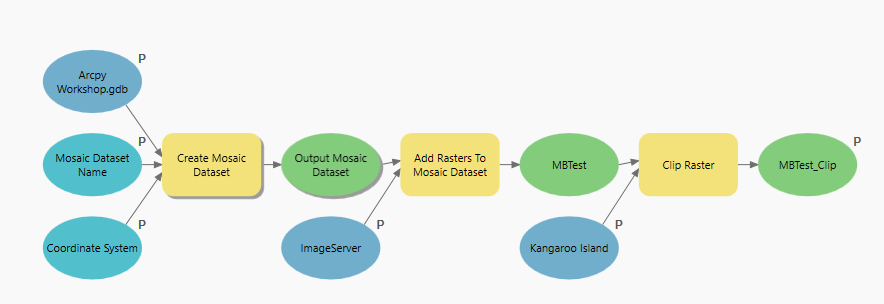

Open ModelBuilder in ArcGIS Pro and replicate the model above.

1. Drag & Drop the Create Mosaic Dataset tool into the ModelBuilder pane. <br>
- Right click the tool, then navigate to Create Variable > From Parameter > Output Location
    - Double Click the variable and set the location to the arcpy_workshop.gdb file geodatabase
    - Right Click the variable and select Parameter
- Right click the tool, then navigate to Create Variable > From Parameter > Mosaic Dataset Name
    - Double Click the variable and set the name to MB_Mosaic
    - Right Click the variable and select Parameter
- Right click the tool, then navigate to Create Variable > From Parameter > Coordinate System
    - Double Click the variable and set the coordinate system to WGS_1984_UTM_Zone_53S
    - Right Click the variable and select Parameter

2. Drag & Drop the Add Raster to Mosaic Dataset tool into the ModelBuilder pane. <br>
- Right click the tool, then navigate to Create Variable > From Parameter > Input Data
    - Double Click the variable and set the input data to the Kangaroo_Island_2019 Image Service located in ArcGIS Online
    - Right Click the variable and select Parameter
- Drag the Output Mosaic Dataset to the Add Rasters to Mosaic Dataset to connect the output to the input. Set it as the Mosaic Dataset.

3. Drag & Drop the Clip Raster tool into the ModelBuilder pane. <br>
- Right click the tool, then navigate to Create Variable > From Parameter > Output Extent
    - Double Click the variable and set the input data to the Kangaroo Island Feature Service located in ArcGIS Online.
    - Right Click the variable and select Parameter
- Drag the Updated Mosaic Dataset output to the Clip Raster tool to connect the output to the input. Set it as the Input Raster.
- Right Click the Output raster variable and select Parameter

Validate, Run, & Save the tool as ```ModelBuilder_Clip```

Now open the tool from the Catalog Pane in ArcGIS Pro by navigating to Toolboxes > arcpy_workshop.atbx > ModelBuilder_Clip. Double click to open the tool as a geoprocessing tool.

### Challenge: Raster Function Template
Similar to ArcGIS ModelBuilder, Raster Function Templates are a way to create reproducible workflows, but with a focus on raster analysis. With the previous example in ModelBuilder, we automated the process for image processing.To automate the image analysis process, then we would could create a Raster Function Template that calculates our Delta NBR. As a challenge, create a Raster Function Template that calculates NBR for each image, then subtracts the two to find Delta NBR.

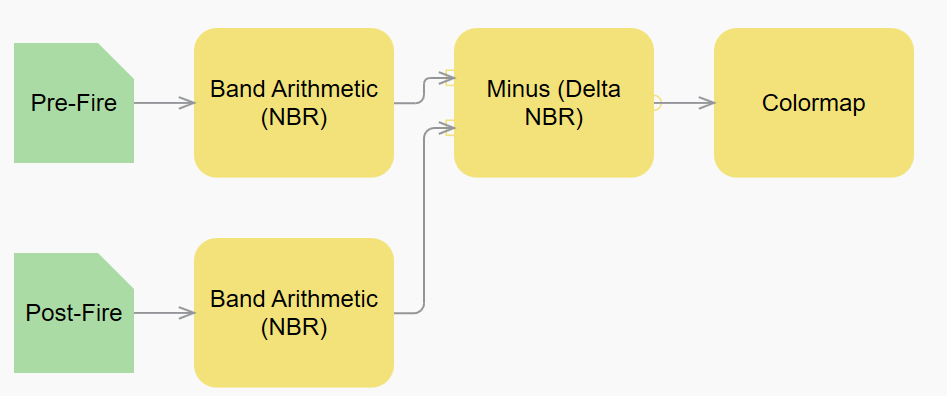